In [2]:
import pandas as pd
import numpy as np 
import io

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Important Functions 

In [2]:
np.append(np.zeros(2),[1,2])

array([0., 0., 1., 2.])

In [3]:
def stacking(groups, padding = 'left'):
    X_group = np.empty(shape=[0, max_length])
    y_group = np.empty(shape=[0, 2])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))
  
        y_group = np.r_[y_group,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
        hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        
        if padding == 'left':
            hash_ = np.append(np.zeros(num_pad),hash_) # padding left
        elif padding == 'right': 
            hash_ = np.append(hash_,np.zeros(num_pad)) # padding right
          
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group, y_group


def stacking_by_chunks(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    y = np.empty(shape=[0, 2])  
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group, y_group = stacking(groups)
        X = np.r_[X,X_group]
        y = np.r_[y,y_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group, y_group = stacking(groups)
    X = np.r_[X,X_group]
    y = np.r_[y,y_group]
    
    return X,y


def stacking_no_y(groups, padding = 'left'):
    X_group = np.empty(shape=[0, max_length])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))

        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        
        if padding == 'left':
            hash_ = np.append(np.zeros(num_pad),hash_) # padding left
        elif padding == 'right': 
            hash_ = np.append(hash_,np.zeros(num_pad)) # padding right
          
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group


def stacking_by_chunks_no_y(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group = stacking_no_y(groups)
        X = np.r_[X,X_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group = stacking_no_y(groups)
    X = np.r_[X,X_group]    
    return X


def city(y,bonus=[0,0]):
    city = np.array([[]])
    bonus = bonus 
    for i in range(np.shape(y)[0]):
        if y[i][0] > 3750901.5068-bonus[0] and y[i][0] < 3770901.5068+bonus[0] and y[i][1] > -19268905.6133-bonus[1] and y[i][1] < -19208905.6133+bonus[1]:
            city = np.append(city,1)
        else:
            city = np.append(city,0)
    return city  



# Loading data

In [38]:
df_train = pd.read_csv('data_train_mod.csv',index_col=0)
df_test = pd.read_csv('data_test_mod.csv',index_col=0)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [40]:
X_train_all = pd.read_csv('X_train_left.csv',index_col=0) # pd.read_csv('X_train.csv',index_col=0)
y_train_all = pd.read_csv('y_train_left.csv',index_col=0) # pd.read_csv('y_train.csv',index_col=0)
X_test = pd.read_csv('X_test_left.csv',index_col=0)
X_train_all = pd.DataFrame(X_train_all)
y_train_all = pd.DataFrame(y_train_all)
X_test = pd.DataFrame(X_test)

In [4]:
print(X_test.shape)
print(X_train_all.shape)
print(y_train_all.shape)

(33515, 198)
(134063, 198)
(134063, 2)


# padding

In [5]:
# padding traning data on left
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2

X_train_left, y_train_left = stacking_by_chunks(df_train)
X_train_left = pd.DataFrame(X_train_left)
y_train_left = pd.DataFrame(y_train_left)
X_train_left.to_csv('X_train_left.csv')
y_train_left.to_csv('y_train_left.csv')

NameError: name 'X_train' is not defined

In [47]:
# padding testing data on left
max_length = max(df_test.groupby("hash").nunique()["trajectory_id"])*10

X_test_left = stacking_by_chunks_no_y(df_test)
X_test_left = pd.DataFrame(X_test_left)
X_test_left.to_csv('X_test_left.csv')

# KNN

In [81]:
# not effective for large dataset
X_train_knn = pd.DataFrame(X_train_all.loc[0:2000])
y_train_knn = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_knn)[0])
test_size = np.shape(X_train_knn)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_knn, y_train_knn, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiknn = MultiOutputRegressor(KNeighborsRegressor())
regr_multiknn.fit(X_train, y_train)
# Predict on new data
y_multiknn = regr_multiknn.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.887500  0.747368  0.811429       285
        1.0   0.552795  0.767241  0.642599       116

avg / total   0.790678  0.753117  0.762590       401

[[213  72]
 [ 27  89]]
0.7531172069825436


<Figure size 432x288 with 0 Axes>

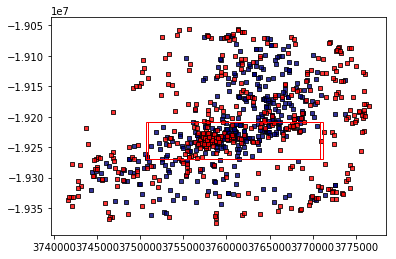

In [88]:
# accuracy 
y_test = np.array(y_test)
a = 250
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiknn[:, 0], y_multiknn[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# decision tree

In [89]:
# not effective for large dataset
X_train_dt = pd.DataFrame(X_train_all.loc[0:2000])
y_train_dt = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_dt)[0])
test_size = np.shape(X_train_dt)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_dt, y_train_dt, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multidt = MultiOutputRegressor(DecisionTreeRegressor(random_state=0))
regr_multidt.fit(X_train, y_train)
# Predict on new data
y_multidt = regr_multidt.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.927536  0.898246  0.912656       285
        1.0   0.768000  0.827586  0.796680       116

avg / total   0.881386  0.877805  0.879107       401

[[256  29]
 [ 20  96]]
0.8778054862842892


<Figure size 432x288 with 0 Axes>

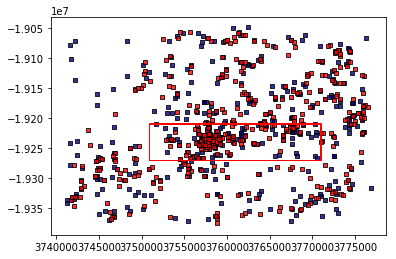

In [98]:
# accuracy 
y_test = np.array(y_test)
a = 100
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multidt[:, 0], y_multidt[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# AdaBoostRegressor

In [99]:
# not effective for large dataset
X_train_ab = pd.DataFrame(X_train_all.loc[0:2000])
y_train_ab = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_ab)[0])
test_size = np.shape(X_train_ab)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_ab, y_train_ab, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiab = MultiOutputRegressor(AdaBoostRegressor(n_estimators=200,random_state=0))
regr_multiab.fit(X_train, y_train)
# Predict on new data
y_multiab = regr_multiab.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.843750  0.757895  0.798521       285
        1.0   0.524138  0.655172  0.582375       116

avg / total   0.751294  0.728180  0.735995       401

[[216  69]
 [ 40  76]]
0.7281795511221946


<Figure size 432x288 with 0 Axes>

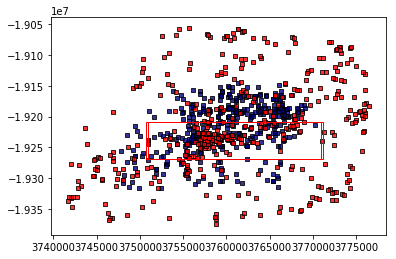

In [107]:
# accuracy 
y_test = np.array(y_test)
a = 200
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiab[:, 0], y_multiab[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# ExtraTreesRegressor

In [108]:
# not effective for large dataset
X_train_et = pd.DataFrame(X_train_all.loc[0:2000])
y_train_et = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_et)[0])
test_size = np.shape(X_train_et)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_et, y_train_et, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiet = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multiet.fit(X_train, y_train)
# Predict on new data
y_multiet = regr_multiet.predict(X_test)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


             precision    recall  f1-score   support

        0.0   0.965385  0.880702  0.921101       285
        1.0   0.758865  0.922414  0.832685       116

avg / total   0.905643  0.892768  0.895524       401

[[251  34]
 [  9 107]]
0.8927680798004988


<Figure size 432x288 with 0 Axes>

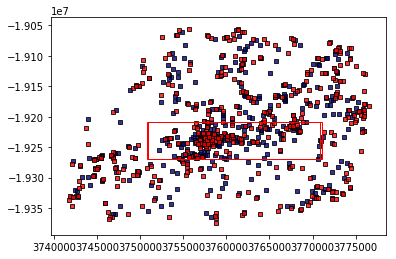

In [118]:
# accuracy 
y_test = np.array(y_test)
a = 150
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiet[:, 0], y_multiet[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# SVR

In [6]:
# not effective for large dataset
X_train_svr = pd.DataFrame(X_train_all.loc[0:2000])
y_train_svr = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_svr)[0])
test_size = np.shape(X_train_svr)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_svr, y_train_svr, train_size=train_size, test_size=test_size, random_state=4)

#grid search
pipe_svr = Pipeline([('scl', StandardScaler()),
        ('reg', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'reg__estimator__C': [0.1,1,10]
}

gs_svr = (GridSearchCV(estimator=pipe_svr, 
                      param_grid=grid_param_svr, 
                      cv=2,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_svr = gs_svr.fit(X_train,y_train)
gs_svr.best_estimator_    

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), 
('reg', MultiOutputRegressor(estimator=SVR(C=10, cache_size=200,
 coef0=0.0, degree=3, epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1,    
 shrinking=True, tol=0.001, verbose=False), n_jobs=1))])

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', MultiOutputRegressor(estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1))])

In [7]:
# svr
regr_multisvr = MultiOutputRegressor(estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)
regr_multisvr.fit(X_train, y_train)
# Predict on new data
y_multisvr = regr_multisvr.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.000000  0.000000  0.000000       285
        1.0   0.289277  1.000000  0.448743       116

avg / total   0.083681  0.289277  0.129811       401

[[  0 285]
 [  0 116]]
0.2892768079800499


/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

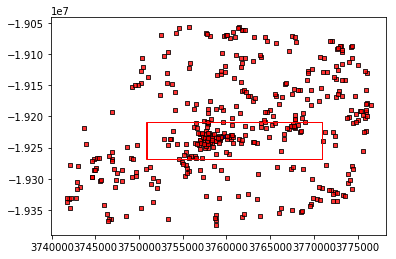

In [9]:
# accuracy 
y_test = np.array(y_test)
a = 60
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multisvr,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multisvr,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multisvr,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multisvr[:, 0], y_multisvr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# random forest

In [17]:
# not effective for large dataset
X_train_rf = pd.DataFrame(X_train_all.loc[0:4000])
y_train_rf = pd.DataFrame(y_train_all.loc[0:4000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_rf)[0])
test_size = np.shape(X_train_rf)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rf, y_train_rf, train_size=train_size, test_size=test_size, random_state=4)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,4,5,7,8,10,12,14,16,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap':bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

KeyboardInterrupt: 

In [11]:
# random forest
X_train = pd.DataFrame(X_train_all.loc[0:4000])
y_train = pd.DataFrame(y_train_all.loc[0:4000])
# n_estimators=222,max_depth=66,min_samples_leaf=4,min_samples_split=5,verbose=True
# n_estimators=250,max_depth=None,min_samples_leaf=7,min_samples_split=14,verbose=True, a=250
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300,max_depth=10 ,min_samples_leaf=7,min_samples_split=7 ,verbose=True,n_jobs=-1))
regr_multirf.fit(X_train, y_train)
# Predict on new data
y_multirf = regr_multirf.predict(X_test)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


In [1]:
print(np.shape(y_multirf))
print(np.shape(X_test))
print(X_train.shape)
print(y_train.shape)

NameError: name 'np' is not defined

             precision    recall  f1-score   support

        0.0   0.979127  0.895833  0.935630       576
        1.0   0.781022  0.951111  0.857715       225

avg / total   0.923480  0.911361  0.913744       801

[[516  60]
 [ 11 214]]
0.9113607990012484


<Figure size 432x288 with 0 Axes>

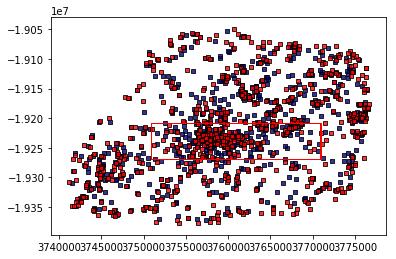

In [12]:
# accuracy 
y_test = np.array(y_test)
a = 60
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [287]:
a = 60
result = pd.DataFrame(city(y_multirf,bonus = [a,3*a]))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


# gradient boosting

In [20]:
# 
X_train_gb = pd.DataFrame(X_train_all.loc[0:2000])
y_train_gb = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_gb)[0])
test_size = np.shape(X_train_gb)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_gb, y_train_gb, train_size=train_size, test_size=test_size, random_state=4)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,7,10,14,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4,6,8,10]
# leatning rate
learning_rate = [0.05,0.1,0.15,0.2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rate}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = GridSearchCV(estimator = gb, param_grid = random_grid, cv = 3, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)

gb_random.best_params_


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/leung0222/anaconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f865a7c1930, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/leung0222/anaconda3/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/leung0.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f865a7c1930, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/leung0222/anaconda3/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/leung0.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1420                         logger.warning('Executing %s took %.3f seconds',
   1421                                        _format_handle(handle), dt)
   1422                 finally:
   1423                     self._current_handle = None
   1424             else:
-> 1425                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1426         handle = None  # Needed to break cycles when an exception occurs.
   1427 
   1428     def _set_coroutine_wrapper(self, enabled):
   1429         try:

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
    122             self._callback = None
    123             self._args = None
    124 
    125     def _run(self):
    126         try:
--> 127             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
    128         except Exception as exc:
    129             cb = _format_callback_source(self._callback, self._args)
    130             msg = 'Exception in callback {}'.format(cb)
    131             context = {

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 5, 10, 14, 44, 12, 346611, tzinfo=tzlocal()), 'msg_id': 'cbcea6059a914d72b97642ed2efc7598', 'msg_type': 'execute_request', 'session': '368f8dd1e31a4acfb1df5fd53ae5aa3a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'cbcea6059a914d72b97642ed2efc7598', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'368f8dd1e31a4acfb1df5fd53ae5aa3a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 5, 10, 14, 44, 12, 346611, tzinfo=tzlocal()), 'msg_id': 'cbcea6059a914d72b97642ed2efc7598', 'msg_type': 'execute_request', 'session': '368f8dd1e31a4acfb1df5fd53ae5aa3a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'cbcea6059a914d72b97642ed2efc7598', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'368f8dd1e31a4acfb1df5fd53ae5aa3a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 5, 10, 14, 44, 12, 346611, tzinfo=tzlocal()), 'msg_id': 'cbcea6059a914d72b97642ed2efc7598', 'msg_type': 'execute_request', 'session': '368f8dd1e31a4acfb1df5fd53ae5aa3a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'cbcea6059a914d72b97642ed2efc7598', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...om.fit(X_train, y_train)\n\ngb_random.best_params_\n', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-20-df29058fcd54>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f86161323c8, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f861388c930, file "<ipython-input-20-df29058fcd54>", line 39>
        result = <ExecutionResult object at 7f86161323c8, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f861388c930, file "<ipython-input-20-df29058fcd54>", line 39>, result=<ExecutionResult object at 7f86161323c8, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f861388c930, file "<ipython-input-20-df29058fcd54>", line 39>
        self.user_global_ns = {'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...w data\ny_multigbr = regr_multigbr.predict(X_test)', 'import pandas as pd\nimport numpy as np \nimport i...sklearn.model_selection import RandomizedSearchCV', "def stacking(groups, padding = 'left'):\n    X_gr...       city = np.append(city,0)\n    return city  ", "X_train_all = pd.read_csv('X_train_left.csv',ind...aFrame(y_train_all)\nX_test = pd.DataFrame(X_test)", '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...w data\ny_multigbr = regr_multigbr.predict(X_test)', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...w data\ny_multigbr = regr_multigbr.predict(X_test)', '# accuracy \ny_test = np.array(y_test)\na = 0\nbonu...x.add_patch(rect1)\nax.add_patch(rect2)\nplt.show()', '# accuracy \ny_test = np.array(y_test)\na = 60\nbon...x.add_patch(rect1)\nax.add_patch(rect2)\nplt.show()', '# accuracy \ny_test = np.array(y_test)\na = 0\nbonu...x.add_patch(rect1)\nax.add_patch(rect2)\nplt.show()', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MultiOutputRegressor': <class 'sklearn.multioutput.MultiOutputRegressor'>, 'Out': {}, ...}
        self.user_ns = {'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...w data\ny_multigbr = regr_multigbr.predict(X_test)', 'import pandas as pd\nimport numpy as np \nimport i...sklearn.model_selection import RandomizedSearchCV', "def stacking(groups, padding = 'left'):\n    X_gr...       city = np.append(city,0)\n    return city  ", "X_train_all = pd.read_csv('X_train_left.csv',ind...aFrame(y_train_all)\nX_test = pd.DataFrame(X_test)", '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...w data\ny_multigbr = regr_multigbr.predict(X_test)', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...w data\ny_multigbr = regr_multigbr.predict(X_test)', '# accuracy \ny_test = np.array(y_test)\na = 0\nbonu...x.add_patch(rect1)\nax.add_patch(rect2)\nplt.show()', '# accuracy \ny_test = np.array(y_test)\na = 60\nbon...x.add_patch(rect1)\nax.add_patch(rect2)\nplt.show()', '# accuracy \ny_test = np.array(y_test)\na = 0\nbonu...x.add_patch(rect1)\nax.add_patch(rect2)\nplt.show()', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# not effective for large dataset\nX_train_rf = p...dom.fit(X_train, y_train)\n\nrf_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', '# \nX_train_gb = pd.DataFrame(X_train_all.loc[0:2...dom.fit(X_train, y_train)\n\ngb_random.best_params_', ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MultiOutputRegressor': <class 'sklearn.multioutput.MultiOutputRegressor'>, 'Out': {}, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/leung0222/gcloud_repos/gcloud_repos/<ipython-input-20-df29058fcd54> in <module>()
     34 gb = GradientBoostingRegressor()
     35 # Random search of parameters, using 3 fold cross validation, 
     36 # search across 100 different combinations, and use all available cores
     37 gb_random = GridSearchCV(estimator = gb, param_grid = random_grid, cv = 3, n_jobs = -1)
     38 # Fit the random search model
---> 39 gb_random.fit(X_train, y_train)
     40 
     41 gb_random.best_params_

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), X=        0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1600 rows x 198 columns], y=                0            1
1736  3743419.554...3764552.446 -19193454.01

[1600 rows x 2 columns], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =         0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1600 rows x 198 columns]
        y =                 0            1
1736  3743419.554...3764552.446 -19193454.01

[1600 rows x 2 columns]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri May 10 14:44:12 2019
PID: 3340                Python 3.5.5: /home/leung0222/anaconda3/bin/python
...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False),         0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1600 rows x 198 columns],                 0            1
1736  3743419.554...3764552.446 -19193454.01

[1600 rows x 2 columns], {'score': <function _passthrough_scorer>}, array([ 534,  535,  536, ..., 1597, 1598, 1599]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 526, 527, 528, 529, 530, 531, 532,
       533]), 0, {'learning_rate': 0.05, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False),         0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1600 rows x 198 columns],                 0            1
1736  3743419.554...3764552.446 -19193454.01

[1600 rows x 2 columns], {'score': <function _passthrough_scorer>}, array([ 534,  535,  536, ..., 1597, 1598, 1599]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 526, 527, 528, 529, 530, 531, 532,
       533]), 0, {'learning_rate': 0.05, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), X=        0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1600 rows x 198 columns], y=                0            1
1736  3743419.554...3764552.446 -19193454.01

[1600 rows x 2 columns], scorer={'score': <function _passthrough_scorer>}, train=array([ 534,  535,  536, ..., 1597, 1598, 1599]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 526, 527, 528, 529, 530, 531, 532,
       533]), verbose=0, parameters={'learning_rate': 0.05, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseGradientBoosting.fit of Gradie...e=1.0, verbose=0,
             warm_start=False)>
        X_train =         0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1066 rows x 198 columns]
        y_train =                 0            1
305   3764368.769...3764552.446 -19193454.01

[1066 rows x 2 columns]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/gradient_boosting.py in fit(self=GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), X=        0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1066 rows x 198 columns], y=                0            1
305   3764368.769...3764552.446 -19193454.01

[1066 rows x 2 columns], sample_weight=None, monitor=None)
    974         # if not warmstart - clear the estimator state
    975         if not self.warm_start:
    976             self._clear_state()
    977 
    978         # Check input
--> 979         X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'], dtype=DTYPE)
        X =         0    1    2    3    4    5    6    7    ...552.446 -19193454.01  

[1066 rows x 198 columns]
        y =                 0            1
305   3764368.769...3764552.446 -19193454.01

[1066 rows x 2 columns]
    980         n_samples, self.n_features_ = X.shape
    981         if sample_weight is None:
    982             sample_weight = np.ones(n_samples, dtype=np.float32)
    983         else:

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py in check_X_y(X=array([[        0. ,         0. ,         0. , ....         3764552.5, -19193454. ]], dtype=float32), y=                0            1
305   3764368.769...3764552.446 -19193454.01

[1066 rows x 2 columns], accept_sparse=['csr', 'csc', 'coo'], dtype=<class 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    573                     ensure_min_features, warn_on_dtype, estimator)
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:
--> 578         y = column_or_1d(y, warn=True)
        y =                 0            1
305   3764368.769...3764552.446 -19193454.01

[1066 rows x 2 columns]
    579         _assert_all_finite(y)
    580     if y_numeric and y.dtype.kind == 'O':
    581         y = y.astype(np.float64)
    582 

...........................................................................
/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py in column_or_1d(y=                0            1
305   3764368.769...3764552.446 -19193454.01

[1066 rows x 2 columns], warn=True)
    609                           " expected. Please change the shape of y to "
    610                           "(n_samples, ), for example using ravel().",
    611                           DataConversionWarning, stacklevel=2)
    612         return np.ravel(y)
    613 
--> 614     raise ValueError("bad input shape {0}".format(shape))
        shape = (1066, 2)
    615 
    616 
    617 def check_random_state(seed):
    618     """Turn seed into a np.random.RandomState instance

ValueError: bad input shape (1066, 2)
___________________________________________________________________________

In [ ]:
X_train_gb = pd.DataFrame(X_train_all)
y_train_gb = pd.DataFrame(y_train_all)
# spliting test/train data 
#train_size = int(0.8*np.shape(X_train_gb)[0])
#test_size = np.shape(X_train_gb)[0]-train_size
#X_train, X_test, y_train, y_test = train_test_split(
#    X_train_gb, y_train_gb, train_size=train_size, test_size=test_size, random_state=4)
# gradient boosting 
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(loss='lad',learning_rate = 0.08, subsample = 0.8, n_estimators=200, max_depth=None,random_state=0,min_samples_leaf = 5, max_features = 'auto',verbose=True))
regr_multigbr.fit(X_train_gb, y_train_gb)
# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        7014.0820         472.5029          347.74m
         2        6532.6066         439.5348          350.46m
         3        6103.6934         402.6436          355.41m
         4        5711.8986         373.1312          363.31m
         5        5349.7651         333.6631          372.20m
         6        4991.3080         314.3634          382.37m
         7        4676.7083         291.5411          391.20m
         8        4369.7485         278.8940          398.17m
         9        4078.0672         255.3257          405.88m
        10        3801.0347         239.6370          413.69m
        20        2000.2325         103.7655          488.38m
        30        1176.8637          38.1808          553.04m
        40         818.2641          11.6600          600.26m
        50         635.7299           3.8391          629.46m
        60         532.3191           1.6884          636.66m
       

             precision    recall  f1-score   support

        0.0     0.9590    0.8900    0.9232       709
        1.0     0.7726    0.9075    0.8346       292

avg / total     0.9046    0.8951    0.8974      1001

[[631  78]
 [ 27 265]]
0.8951048951048951


<Figure size 432x288 with 0 Axes>

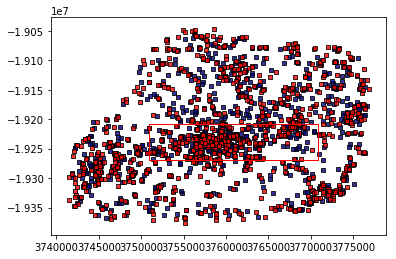

In [39]:
# loss='lad',learning_rate = 0.08, n_estimators=150, 
# max_depth=None,random_state=0,min_samples_leaf = 5, max_features = 'auto',verbose=True -----> 0.8594, 0.9144
# accuracy 
y_test = np.array(y_test)
a = 0
bonus = [a,3*a]
print (classification_report(city(y_test), city(y_multigbr,bonus=bonus),digits = 4))
print (confusion_matrix(city(y_test), city(y_multigbr,bonus=bonus)))
print (accuracy_score(city(y_test), city(y_multigbr,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multigbr[:, 0], y_multigbr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# minibatch SGDClassifier - no good at all

In [74]:
X_train_SGD = pd.DataFrame(X_train_all)
y_train_SGD = pd.DataFrame(y_train_all)
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_SGD)[0])
test_size = np.shape(X_train_SGD)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_SGD, y_train_SGD, train_size=train_size, test_size=test_size, random_state=4)

regr_SGD = linear_model.SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,verbose = True)

regr_SGD.fit(X_train, city(np.array(y_train),bonus=[500,2000]))
# Predict on new data
y_SGD = regr_SGD.predict(X_test)


-- Epoch 1
Norm: 27095291.64, NNZs: 195, Bias: -14.855364, T: 107250, Avg. loss: 392839284198682.375000
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 21597848.45, NNZs: 195, Bias: -16.169981, T: 214500, Avg. loss: 58003719648532.179688
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 20039950.67, NNZs: 195, Bias: -16.858357, T: 321750, Avg. loss: 33970955876032.894531
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 19285786.25, NNZs: 195, Bias: -17.303465, T: 429000, Avg. loss: 23962708274755.816406
Total training time: 0.46 seconds.
-- Epoch 5
Norm: 19137339.61, NNZs: 195, Bias: -17.674602, T: 536250, Avg. loss: 18615709622954.464844
Total training time: 0.58 seconds.
-- Epoch 6
Norm: 18781571.92, NNZs: 195, Bias: -17.964002, T: 643500, Avg. loss: 15226856372517.259766
Total training time: 0.70 seconds.
-- Epoch 7
Norm: 18465105.71, NNZs: 195, Bias: -18.224214, T: 750750, Avg. loss: 12906801549322.269531
Total training time: 0.81 seconds.
-- Epoch 8
Norm: 18157591.88, NNZ

Norm: 9657732.72, NNZs: 195, Bias: -20.886973, T: 6435000, Avg. loss: 1398426382377.162354
Total training time: 6.89 seconds.
-- Epoch 61
Norm: 9551117.76, NNZs: 195, Bias: -20.899281, T: 6542250, Avg. loss: 1374697619619.526367
Total training time: 7.01 seconds.
-- Epoch 62
Norm: 9450301.76, NNZs: 195, Bias: -20.908366, T: 6649500, Avg. loss: 1350896502781.951416
Total training time: 7.13 seconds.
-- Epoch 63
Norm: 9360488.07, NNZs: 195, Bias: -20.924751, T: 6756750, Avg. loss: 1324892364126.022461
Total training time: 7.25 seconds.
-- Epoch 64
Norm: 9255730.10, NNZs: 195, Bias: -20.932087, T: 6864000, Avg. loss: 1308321195638.014404
Total training time: 7.37 seconds.
-- Epoch 65
Norm: 9149142.86, NNZs: 195, Bias: -20.945106, T: 6971250, Avg. loss: 1290096621076.104248
Total training time: 7.48 seconds.
-- Epoch 66
Norm: 9047121.71, NNZs: 195, Bias: -20.957896, T: 7078500, Avg. loss: 1271524079072.055664
Total training time: 7.59 seconds.
-- Epoch 67
Norm: 8959444.96, NNZs: 195, Bias:

Norm: 5800923.29, NNZs: 195, Bias: -21.363431, T: 12870000, Avg. loss: 691408232848.581787
Total training time: 13.73 seconds.
-- Epoch 121
Norm: 5767732.23, NNZs: 195, Bias: -21.368060, T: 12977250, Avg. loss: 688074546907.242554
Total training time: 13.84 seconds.
-- Epoch 122
Norm: 5718625.34, NNZs: 195, Bias: -21.371892, T: 13084500, Avg. loss: 682303560182.999023
Total training time: 13.95 seconds.
-- Epoch 123
Norm: 5682538.57, NNZs: 195, Bias: -21.377218, T: 13191750, Avg. loss: 677172474297.022949
Total training time: 14.05 seconds.
-- Epoch 124
Norm: 5641405.32, NNZs: 195, Bias: -21.382499, T: 13299000, Avg. loss: 673257920459.613647
Total training time: 14.16 seconds.
-- Epoch 125
Norm: 5607360.72, NNZs: 195, Bias: -21.387737, T: 13406250, Avg. loss: 667654798005.918457
Total training time: 14.27 seconds.
-- Epoch 126
Norm: 5574144.56, NNZs: 195, Bias: -21.392935, T: 13513500, Avg. loss: 661825685081.770752
Total training time: 14.38 seconds.
-- Epoch 127
Norm: 5533275.21, NN

Norm: 4140168.88, NNZs: 195, Bias: -21.613216, T: 19305000, Avg. loss: 460813382064.956055
Total training time: 20.82 seconds.
-- Epoch 181
Norm: 4127045.78, NNZs: 195, Bias: -21.616835, T: 19412250, Avg. loss: 460083818826.907776
Total training time: 20.95 seconds.
-- Epoch 182
Norm: 4108295.78, NNZs: 195, Bias: -21.620432, T: 19519500, Avg. loss: 458659669940.061401
Total training time: 21.06 seconds.
-- Epoch 183
Norm: 4083966.74, NNZs: 195, Bias: -21.623498, T: 19626750, Avg. loss: 455962325023.839722
Total training time: 21.18 seconds.
-- Epoch 184
Norm: 4071773.25, NNZs: 195, Bias: -21.627562, T: 19734000, Avg. loss: 453504683627.116821
Total training time: 21.31 seconds.
-- Epoch 185
Norm: 4057785.45, NNZs: 195, Bias: -21.632108, T: 19841250, Avg. loss: 450263352947.818787
Total training time: 21.43 seconds.
-- Epoch 186
Norm: 4040484.83, NNZs: 195, Bias: -21.634115, T: 19948500, Avg. loss: 443618008126.074097
Total training time: 21.55 seconds.
-- Epoch 187
Norm: 4023169.71, NN

Norm: 3278712.32, NNZs: 195, Bias: -21.789646, T: 25740000, Avg. loss: 347785930320.520264
Total training time: 27.72 seconds.
-- Epoch 241
Norm: 3271490.63, NNZs: 195, Bias: -21.791975, T: 25847250, Avg. loss: 344707808211.376282
Total training time: 27.84 seconds.
-- Epoch 242
Norm: 3261490.90, NNZs: 195, Bias: -21.795451, T: 25954500, Avg. loss: 343008376433.894348
Total training time: 27.95 seconds.
-- Epoch 243
Norm: 3250872.64, NNZs: 195, Bias: -21.798525, T: 26061750, Avg. loss: 342599845702.897278
Total training time: 28.07 seconds.
-- Epoch 244
Norm: 3235762.96, NNZs: 195, Bias: -21.799673, T: 26169000, Avg. loss: 339669261263.641418
Total training time: 28.18 seconds.
-- Epoch 245
Norm: 3225284.31, NNZs: 195, Bias: -21.802342, T: 26276250, Avg. loss: 339181573911.130127
Total training time: 28.30 seconds.
-- Epoch 246
Norm: 3213092.59, NNZs: 195, Bias: -21.804619, T: 26383500, Avg. loss: 337441578149.497192
Total training time: 28.42 seconds.
-- Epoch 247
Norm: 3198268.26, NN

Norm: 2716173.11, NNZs: 195, Bias: -21.924852, T: 32175000, Avg. loss: 277589865108.085938
Total training time: 34.38 seconds.
-- Epoch 301
Norm: 2711473.11, NNZs: 195, Bias: -21.927333, T: 32282250, Avg. loss: 275337928922.366638
Total training time: 34.49 seconds.
-- Epoch 302
Norm: 2703217.58, NNZs: 195, Bias: -21.928260, T: 32389500, Avg. loss: 276658775100.152161
Total training time: 34.59 seconds.
-- Epoch 303
Norm: 2697791.90, NNZs: 195, Bias: -21.931035, T: 32496750, Avg. loss: 274559688037.602081
Total training time: 34.70 seconds.
-- Epoch 304
Norm: 2689534.32, NNZs: 195, Bias: -21.932878, T: 32604000, Avg. loss: 275044424446.100769
Total training time: 34.81 seconds.
-- Epoch 305
Norm: 2682456.79, NNZs: 195, Bias: -21.934714, T: 32711250, Avg. loss: 272471401110.599335
Total training time: 34.91 seconds.
-- Epoch 306
Norm: 2676533.15, NNZs: 195, Bias: -21.936241, T: 32818500, Avg. loss: 271428241043.799469
Total training time: 35.02 seconds.
-- Epoch 307
Norm: 2670453.75, NN

Norm: 2313222.84, NNZs: 195, Bias: -22.034722, T: 38610000, Avg. loss: 230119495576.020691
Total training time: 41.19 seconds.
-- Epoch 361
Norm: 2306662.59, NNZs: 195, Bias: -22.036274, T: 38717250, Avg. loss: 229788475324.456696
Total training time: 41.30 seconds.
-- Epoch 362
Norm: 2305371.92, NNZs: 195, Bias: -22.037821, T: 38824500, Avg. loss: 229349518273.265503
Total training time: 41.42 seconds.
-- Epoch 363
Norm: 2298897.36, NNZs: 195, Bias: -22.039109, T: 38931750, Avg. loss: 229545020176.432037
Total training time: 41.54 seconds.
-- Epoch 364
Norm: 2295760.28, NNZs: 195, Bias: -22.041161, T: 39039000, Avg. loss: 228133987204.624817
Total training time: 41.66 seconds.
-- Epoch 365
Norm: 2287623.33, NNZs: 195, Bias: -22.042696, T: 39146250, Avg. loss: 227696291307.965515
Total training time: 41.78 seconds.
-- Epoch 366
Norm: 2283524.46, NNZs: 195, Bias: -22.044992, T: 39253500, Avg. loss: 229070620209.570343
Total training time: 41.90 seconds.
-- Epoch 367
Norm: 2278991.52, NN

Norm: 2041556.71, NNZs: 195, Bias: -22.128405, T: 45045000, Avg. loss: 197802065254.479218
Total training time: 48.19 seconds.
-- Epoch 421
Norm: 2037716.90, NNZs: 195, Bias: -22.129514, T: 45152250, Avg. loss: 198098748770.645172
Total training time: 48.31 seconds.
-- Epoch 422
Norm: 2036841.05, NNZs: 195, Bias: -22.131505, T: 45259500, Avg. loss: 195775673936.504883
Total training time: 48.42 seconds.
-- Epoch 423
Norm: 2031016.05, NNZs: 195, Bias: -22.133049, T: 45366750, Avg. loss: 197035298736.873810
Total training time: 48.54 seconds.
-- Epoch 424
Norm: 2028178.11, NNZs: 195, Bias: -22.134150, T: 45474000, Avg. loss: 196050090321.061646
Total training time: 48.67 seconds.
-- Epoch 425
Norm: 2026259.83, NNZs: 195, Bias: -22.136345, T: 45581250, Avg. loss: 195828073321.115204
Total training time: 48.78 seconds.
-- Epoch 426
Norm: 2020996.86, NNZs: 195, Bias: -22.137003, T: 45688500, Avg. loss: 195846565860.534241
Total training time: 48.90 seconds.
-- Epoch 427
Norm: 2017856.32, NN

Norm: 1834624.10, NNZs: 195, Bias: -22.209761, T: 51480000, Avg. loss: 172807478821.210876
Total training time: 55.16 seconds.
-- Epoch 481
Norm: 1831560.03, NNZs: 195, Bias: -22.210925, T: 51587250, Avg. loss: 173322036019.646210
Total training time: 55.27 seconds.
-- Epoch 482
Norm: 1828397.30, NNZs: 195, Bias: -22.212280, T: 51694500, Avg. loss: 173295783635.791962
Total training time: 55.39 seconds.
-- Epoch 483
Norm: 1825053.54, NNZs: 195, Bias: -22.213632, T: 51801750, Avg. loss: 171609721095.584106
Total training time: 55.51 seconds.
-- Epoch 484
Norm: 1823606.01, NNZs: 195, Bias: -22.214596, T: 51909000, Avg. loss: 170793322660.658173
Total training time: 55.63 seconds.
-- Epoch 485
Norm: 1820067.64, NNZs: 195, Bias: -22.215558, T: 52016250, Avg. loss: 171072175409.304871
Total training time: 55.74 seconds.
-- Epoch 486
Norm: 1818359.58, NNZs: 195, Bias: -22.216903, T: 52123500, Avg. loss: 171505906397.780304
Total training time: 55.86 seconds.
-- Epoch 487
Norm: 1813414.58, NN

Norm: 1662628.27, NNZs: 195, Bias: -22.281490, T: 57915000, Avg. loss: 152888855321.673279
Total training time: 61.92 seconds.
-- Epoch 541
Norm: 1660251.08, NNZs: 195, Bias: -22.282698, T: 58022250, Avg. loss: 152953003302.888123
Total training time: 62.03 seconds.
-- Epoch 542
Norm: 1659555.40, NNZs: 195, Bias: -22.283904, T: 58129500, Avg. loss: 152773888508.574890
Total training time: 62.13 seconds.
-- Epoch 543
Norm: 1657066.76, NNZs: 195, Bias: -22.284935, T: 58236750, Avg. loss: 153886074890.297363
Total training time: 62.24 seconds.
-- Epoch 544
Norm: 1653828.08, NNZs: 195, Bias: -22.286307, T: 58344000, Avg. loss: 153681915824.010284
Total training time: 62.34 seconds.
-- Epoch 545
Norm: 1652657.99, NNZs: 195, Bias: -22.287677, T: 58451250, Avg. loss: 152586482461.035706
Total training time: 62.46 seconds.
-- Epoch 546
Norm: 1648491.64, NNZs: 195, Bias: -22.288360, T: 58558500, Avg. loss: 151527060496.129639
Total training time: 62.58 seconds.
-- Epoch 547
Norm: 1645330.59, NN

Norm: 1531540.64, NNZs: 195, Bias: -22.345488, T: 64350000, Avg. loss: 138315423375.704102
Total training time: 68.65 seconds.
-- Epoch 601
Norm: 1529047.10, NNZs: 195, Bias: -22.345954, T: 64457250, Avg. loss: 138700962741.210510
Total training time: 68.76 seconds.
-- Epoch 602
Norm: 1525406.14, NNZs: 195, Bias: -22.347194, T: 64564500, Avg. loss: 137455426570.601715
Total training time: 68.88 seconds.
-- Epoch 603
Norm: 1524242.61, NNZs: 195, Bias: -22.347968, T: 64671750, Avg. loss: 137216250707.168915
Total training time: 68.99 seconds.
-- Epoch 604
Norm: 1521702.77, NNZs: 195, Bias: -22.349049, T: 64779000, Avg. loss: 137716548795.124908
Total training time: 69.11 seconds.
-- Epoch 605
Norm: 1519448.74, NNZs: 195, Bias: -22.350129, T: 64886250, Avg. loss: 138326109045.949982
Total training time: 69.23 seconds.
-- Epoch 606
Norm: 1517528.67, NNZs: 195, Bias: -22.351053, T: 64993500, Avg. loss: 137897559570.704041
Total training time: 69.35 seconds.
-- Epoch 607
Norm: 1514795.57, NN

Norm: 1416945.00, NNZs: 195, Bias: -22.401897, T: 70785000, Avg. loss: 125331334014.445755
Total training time: 75.39 seconds.
-- Epoch 661
Norm: 1416888.48, NNZs: 195, Bias: -22.402602, T: 70892250, Avg. loss: 125709165619.772949
Total training time: 75.51 seconds.
-- Epoch 662
Norm: 1414005.98, NNZs: 195, Bias: -22.403871, T: 70999500, Avg. loss: 125424089381.079727
Total training time: 75.63 seconds.
-- Epoch 663
Norm: 1411597.98, NNZs: 195, Bias: -22.404293, T: 71106750, Avg. loss: 125208759074.215607
Total training time: 75.75 seconds.
-- Epoch 664
Norm: 1409252.90, NNZs: 195, Bias: -22.405136, T: 71214000, Avg. loss: 125628727715.554535
Total training time: 75.86 seconds.
-- Epoch 665
Norm: 1408090.30, NNZs: 195, Bias: -22.405978, T: 71321250, Avg. loss: 124766700749.313553
Total training time: 75.98 seconds.
-- Epoch 666
Norm: 1405678.62, NNZs: 195, Bias: -22.407099, T: 71428500, Avg. loss: 125200787339.732788
Total training time: 76.10 seconds.
-- Epoch 667
Norm: 1405405.98, NN

Norm: 1316869.26, NNZs: 195, Bias: -22.454060, T: 77220000, Avg. loss: 115161192612.060516
Total training time: 82.19 seconds.
-- Epoch 721
Norm: 1316668.80, NNZs: 195, Bias: -22.454578, T: 77327250, Avg. loss: 115018826732.788986
Total training time: 82.30 seconds.
-- Epoch 722
Norm: 1314184.57, NNZs: 195, Bias: -22.455353, T: 77434500, Avg. loss: 115953499449.031036
Total training time: 82.41 seconds.
-- Epoch 723
Norm: 1311547.39, NNZs: 195, Bias: -22.455999, T: 77541750, Avg. loss: 114257117031.519211
Total training time: 82.51 seconds.
-- Epoch 724
Norm: 1309664.61, NNZs: 195, Bias: -22.456643, T: 77649000, Avg. loss: 115049348533.284393
Total training time: 82.62 seconds.
-- Epoch 725
Norm: 1307333.78, NNZs: 195, Bias: -22.457930, T: 77756250, Avg. loss: 114703472392.932098
Total training time: 82.73 seconds.
-- Epoch 726
Norm: 1306698.92, NNZs: 195, Bias: -22.458187, T: 77863500, Avg. loss: 114273493656.648407
Total training time: 82.83 seconds.
-- Epoch 727
Norm: 1304629.10, NN

Norm: 1239331.37, NNZs: 195, Bias: -22.501919, T: 83655000, Avg. loss: 106533849197.113678
Total training time: 88.78 seconds.
-- Epoch 781
Norm: 1238663.65, NNZs: 195, Bias: -22.502636, T: 83762250, Avg. loss: 105801318023.282654
Total training time: 88.88 seconds.
-- Epoch 782
Norm: 1238102.06, NNZs: 195, Bias: -22.503710, T: 83869500, Avg. loss: 105997226983.050430
Total training time: 88.99 seconds.
-- Epoch 783
Norm: 1237737.45, NNZs: 195, Bias: -22.504663, T: 83976750, Avg. loss: 106200154952.976593
Total training time: 89.10 seconds.
-- Epoch 784
Norm: 1236101.42, NNZs: 195, Bias: -22.505377, T: 84084000, Avg. loss: 106008499675.042511
Total training time: 89.21 seconds.
-- Epoch 785
Norm: 1234380.93, NNZs: 195, Bias: -22.506090, T: 84191250, Avg. loss: 105638759444.125244
Total training time: 89.32 seconds.
-- Epoch 786
Norm: 1232685.92, NNZs: 195, Bias: -22.506565, T: 84298500, Avg. loss: 105228255907.953857
Total training time: 89.43 seconds.
-- Epoch 787
Norm: 1230806.60, NN

Norm: 1175589.51, NNZs: 195, Bias: -22.546609, T: 90090000, Avg. loss: 99473413036.909561
Total training time: 95.53 seconds.
-- Epoch 841
Norm: 1174872.47, NNZs: 195, Bias: -22.547496, T: 90197250, Avg. loss: 98704206311.253098
Total training time: 95.64 seconds.
-- Epoch 842
Norm: 1174389.06, NNZs: 195, Bias: -22.548050, T: 90304500, Avg. loss: 98390738414.665268
Total training time: 95.75 seconds.
-- Epoch 843
Norm: 1173320.53, NNZs: 195, Bias: -22.548825, T: 90411750, Avg. loss: 98419348360.098129
Total training time: 95.85 seconds.
-- Epoch 844
Norm: 1172346.00, NNZs: 195, Bias: -22.549599, T: 90519000, Avg. loss: 98210855379.063126
Total training time: 95.96 seconds.
-- Epoch 845
Norm: 1171548.07, NNZs: 195, Bias: -22.550261, T: 90626250, Avg. loss: 98880767735.184250
Total training time: 96.06 seconds.
-- Epoch 846
Norm: 1171748.57, NNZs: 195, Bias: -22.551254, T: 90733500, Avg. loss: 98289179228.919464
Total training time: 96.17 seconds.
-- Epoch 847
Norm: 1170131.66, NNZs: 195

Norm: 1119078.21, NNZs: 195, Bias: -22.588223, T: 96525000, Avg. loss: 92303082899.563782
Total training time: 102.18 seconds.
-- Epoch 901
Norm: 1118297.79, NNZs: 195, Bias: -22.588948, T: 96632250, Avg. loss: 91896898432.652695
Total training time: 102.29 seconds.
-- Epoch 902
Norm: 1118925.23, NNZs: 195, Bias: -22.589672, T: 96739500, Avg. loss: 91975030045.398895
Total training time: 102.40 seconds.
-- Epoch 903
Norm: 1119267.42, NNZs: 195, Bias: -22.590602, T: 96846750, Avg. loss: 91562706962.563354
Total training time: 102.51 seconds.
-- Epoch 904
Norm: 1118464.70, NNZs: 195, Bias: -22.591014, T: 96954000, Avg. loss: 92476225307.133896
Total training time: 102.63 seconds.
-- Epoch 905
Norm: 1117464.41, NNZs: 195, Bias: -22.591736, T: 97061250, Avg. loss: 91611270767.356873
Total training time: 102.75 seconds.
-- Epoch 906
Norm: 1117036.82, NNZs: 195, Bias: -22.592559, T: 97168500, Avg. loss: 91418955575.269943
Total training time: 102.86 seconds.
-- Epoch 907
Norm: 1115947.00, NN

Norm: 1068032.40, NNZs: 195, Bias: -22.626836, T: 102960000, Avg. loss: 86537612108.956818
Total training time: 109.12 seconds.
-- Epoch 961
Norm: 1067373.69, NNZs: 195, Bias: -22.627515, T: 103067250, Avg. loss: 86032304713.902664
Total training time: 109.24 seconds.
-- Epoch 962
Norm: 1065995.83, NNZs: 195, Bias: -22.628194, T: 103174500, Avg. loss: 86084914912.769821
Total training time: 109.35 seconds.
-- Epoch 963
Norm: 1064267.36, NNZs: 195, Bias: -22.628581, T: 103281750, Avg. loss: 86248557756.713425
Total training time: 109.47 seconds.
-- Epoch 964
Norm: 1064467.78, NNZs: 195, Bias: -22.629259, T: 103389000, Avg. loss: 86508840508.729248
Total training time: 109.59 seconds.
-- Epoch 965
Norm: 1064055.97, NNZs: 195, Bias: -22.629839, T: 103496250, Avg. loss: 85603339743.030869
Total training time: 109.71 seconds.
-- Epoch 966
Norm: 1063096.55, NNZs: 195, Bias: -22.630515, T: 103603500, Avg. loss: 86452516032.608902
Total training time: 109.83 seconds.
-- Epoch 967
Norm: 1062847

In [75]:
# accuracy 
y_test = np.array(y_test)
print (classification_report(city(y_test), y_SGD,digits = 4))
print (confusion_matrix(city(y_test), y_SGD))
print (accuracy_score(city(y_test), y_SGD))
print(y_SGD[0:10])

/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0     0.7298    1.0000    0.8438     19567
        1.0     0.0000    0.0000    0.0000      7246

avg / total     0.5325    0.7298    0.6157     26813

[[19567     0]
 [ 7246     0]]
0.7297579532316414
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# chunks of ramdon forests - doesn't make a difference

In [77]:
def generate_rf(X_train, y_train):
    rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0))
    rf.fit(X_train, y_train)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

def fitting_by_chunks(X_train, y_train,num_rfs = 100):
    num_samples = len(y_train)
    # the less ramdom forests the better but slower  
    chunk_size = int(num_samples/num_rfs)
    #last_chunk = num_groups - chunk_size*num_iter
    
    X_train_rf = X_train[0:chunk_size]
    y_train_rf = y_train[0:chunk_size]
    rfs = generate_rf(X_train_rf, y_train_rf)

    for i in range(2,num_rfs+1):
        X_train_rf = X_train[(i-1)*chunk_size:i*chunk_size]
        y_train_rf = y_train[(i-1)*chunk_size:i*chunk_size]
        rf = generate_rf(X_train_rf, y_train_rf)
        rfs = combine_rfs(rfs,rf)

    #last chunk
    if num_samples != num_rfs*chunk_size:
        X_train = X_train[num_rfs*chunk_size:num_samples]
        y_train = y_train[num_rfs*chunk_size:num_samples]
        rf = generate_rf(X_train, y_train)
        rfs = combine_rfs(rfs,rf)
    
    return rfs


In [78]:
# not effective for large dataset
X_train_rfs = pd.DataFrame(X_train_all.loc[0:20000])
y_train_rfs = pd.DataFrame(y_train_all.loc[0:20000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_rfs)[0])
test_size = np.shape(X_train_rfs)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rfs, y_train_rfs, train_size=train_size, test_size=test_size, random_state=4)

rfs = fitting_by_chunks(X_train, y_train,num_rfs = 10)
y_multirfs = rfs.predict(X_test)

In [165]:
city_list = np.array([[]])
bonus = [500,2000]
for i in range (np.shape(y_multirfs)[0]):
    city = 0
    for j in range (1,np.shape(y_multirfs)[1]+1):
        y = np.array(y_multirfs[i][0:2*j])
        if y[0] > 3750901.5068-bonus[0] and y[0] < 3770901.5068+bonus[0] and y[1] > -19268905.6133-bonus[1] and y[1] < -19208905.6133+bonus[1]:
            city = city + 1
    if city > np.shape(y_multirfs)[1]/4:
        city_list = np.append(city_list,1)
    else:
        city_list = np.append(city_list,0)
# accuracy 
y_test = np.array(y_test)
city_list = np.array([city_list])
print (classification_report(city(y_test,bonus=[0,0]), city_list,digits = 4))
print (confusion_matrix(city(y_test,bonus=[0,0]), city_list))
print (accuracy_score(city(y_test,bonus=[0,0]), city_list))
          


TypeError: 'int' object is not callable

In [166]:
print(np.shape(city(y_test,bonus=[0,0])))
print(np.shape(city_list),np.shape(y_test),np.shape(y_multirfs),city_list[0:10],y_test[0:10])


TypeError: 'int' object is not callable

In [177]:
result = pd.DataFrame(city_list)

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


In [196]:
for i in range (9):
    city = 0
    for j in range (1,np.shape(y_predict)[1]+1):
        y = np.array(y_predict[i][0:2*j])
        if y[0] > 3750901.5068 and y[0] < 3770901.5068 and y[1] > -19268905.6133 and y[1] < -19208905.6133:
            city = city + 1
print(city)

202


# final model

In [ ]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = chosen_model.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))
result.to_csv('result.csv')

In [113]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = regr_multigbr.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


array([0., 0., 0., 0., 0.])